## Matthieu Neau

In [222]:
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import string

# HW Instructions

## 🚧 Cells
All the cells identified with a 🚧 should be completed, either by a code or an written answer.
You can add as many cells as you want, but in general cells are already in place.


🚧 **TODO** 🚧

*Requires to complete a code (can be completed with optional text cells if you find it relevant).*

or

🚧 **Question** 🚧

*Requires a written answer (can be completed with optional code cells if you find it relevant).*

## 🔴 Test cells
Cells identified with 🔴 should be left untouched and shouldn't return any error.

## Presentation
The overall presentation of the notebook will account in the grading process.
Some advice:
- Give title to your figures.
- Put legends on the figures.
- Comment the figures if they are not self-explanatory.
- Add comment in the code if not self-explanatory.
- Review your notebook before submitting.
- Feel free to add any additional illustration if you find it will bring something.
- Remain as concise as possible when answering written answer, emphasize the important points.

**We cannot debug every notebooks. The notebook should run entirely from the start to the end without any error. If one cell returns an error during the execution, only the cells before the error will be graded.**



# HW Introduction

## Hands on with NLP preprocessing

The goal of this first homework is to introduce the preprocessing steps in NLP. This step is necessary, very valuable but often not emphasized enough (because it is boring). 

## Plan

1. Load the data
2. Analyze and clean the text data
3. Format the texts for Deep Learning models and pytorch (i.e. tokenize, etc).

## Notations

Throughout the HW, a text will be called either **document** or **text**.


# I - Data loading

In [223]:
def download_imdb(output_path: str, force_download: bool = False):
    """Save the data to `output_path`."""
    output_path = Path(output_path)
    if (not output_path.is_file()) or force_download:
        gdd.download_file_from_google_drive(
            file_id="1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz",
            dest_path=output_path,
        )
    return

In [224]:
DATA_PATH = "data/imdb_reviews.csv"
download_imdb(output_path=DATA_PATH, force_download=False)

🚧 **TODO** 🚧

Read the file to a Pandas dataframe (the file is stored as a csv). Make sure the "review" field is of dtype `string` and label of dtype `int`.

Hint: https://pandas.pydata.org/docs/user_guide/text.html (you can specify the `dtype` argument of pandas constructor).


In [225]:
df_imdb = pd.read_csv(DATA_PATH, dtype={"review": "string", "label": int})

In [226]:
text_column = df_imdb["review"]
label_column = df_imdb["label"]
print(text_column.dtype)

string


🔴 **TEST**

In [227]:
assert label_column.dtype == int
assert text_column.dtype == "string"

🚧 **TODO** 🚧

Print some values of the dataframe.
- Print 3 samples of text.
- Print their associated labels.
- Print some statistics of the dataset.



In [228]:
print("==== 3 first texts ====")
print(text_column.head(3))


print("\n==== Associated labels of the 3 first texts ====")
print(label_column.head(3))


print("\n=== Dataset statistics ===")
print("Number of texts")
print(len(text_column))


print("\nAverage text length (in characters)")
print(text_column.str.len().mean())


print("\n% of positive texts")
print((label_column.mean() * 100).round(2))

==== 3 first texts ====
0    Once again Mr. Costner has dragged out a movie...
1    This is an example of why the majority of acti...
2    First of all I hate those moronic rappers, who...
Name: review, dtype: string

==== Associated labels of the 3 first texts ====
0    0
1    0
2    0
Name: label, dtype: int64

=== Dataset statistics ===
Number of texts
62155

Average text length (in characters)
1374.0382431019227

% of positive texts
49.67


## II - Clean and format the data.
For this first TP, we want to focus on very simple tasks.
Therefore, we want to avoid as much as possible rare and uncommon words that will be considered as outliers.

We will try to figure out what kind of cleaning we can perform, by having a look at the data.

The plan for this part will be:
1. Split the strings as a list of words.
2. Find the outliers in the corpus.
3. Propose some methods to clean them.

### 1. Tokenization
First, we will split our texts into words.
Splitting a string into a list of smaller substrings is called **tokenization**, and the substrings are called **tokens**.

The simplest way to tokenize a text is to split it by words, according to whitespaces.

Then, each word encountered in the training set is stored and uniquely identified through an id.



🚧 **Question** 🚧

By doing so, we put a huge emphasis on words within documents.

a) Intuitively, why is it relevant? For instance compare to splitting by character.

b) Cite some methods discussed during the course that rely on word-based representations of documents.

**Answer**

a) It is relevant to put emphasis on words as each word has its own meaning. It is also an efficient way to proceed as tokenization can easily be computed. However, it also has its drawbacks such as:
- Not being able to understand different semantic meanings to the same word
- A fairly big dictionary (list of tokens available)
- Hard to deal with Out of Vocabulary Words

Splitting by character would remove the second drawback but is usually not used because a character by itself does not carry a lot of meaning

b) Word2Vec, Glove, Skip Gram

🚧 **TODO** 🚧

Implement a tokenizer based on whitespace splitting. For now, the tokenizer should only be able to store each unique word found in the dataset.

In [229]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split(" ")

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None
                if token_not_in_vocab:
                    self.vocab[token] = current_id
                    self.id_to_token[current_id] = token
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)
        print(f"Built a vocabulary of {self.num_words} words.")

🔴 **TEST**

In [230]:
toy_corpus = ["a cat", "a dog"]
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(toy_corpus)
assert tokenizer.vocab == {"a": 0, "cat": 1, "dog": 2}
assert tokenizer.frequencies == {0: 2, 1: 1, 2: 1}
assert tokenizer.num_words == 3

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 3 words.


🚧 **TODO** 🚧

Fits the tokenizer on the imdb reviews.

In [231]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(text_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 475277 words.


### 2. Noise analysis

🚧 **TODO** 🚧

Print 50 random tokens.

In [232]:
random.seed(0)
print(random.sample(list(tokenizer.vocab.keys()), 50))

['\\"city', 'insidious,', 'movie.Brought', 'Doolittle\\"', 'Avril', 'borderlined', 'Hosmer', "Wyngarde's", 'Ricks.', 'naysayers,', 'Deverell', 'strong-spirited', 'prophecy', 'Laresca', 'Hendrix.', 'brother!!)', '\\"Cement\\"', 'directed...', "/>'Never'", 'Chance,', 'HonestlyÂ?', 'Literally', 'Fought', 'homophobic', 'Heroes.', 'Days...so', 'Porter,', 'room...at', 'doom-filled', 'osteopath,...<br', 'colonizing', '\\Hello\\"', 'Drury', 'ELIZABETH)', 'director/low', '(f.ex.', 'reeked.', 'Trees\\"', '\\"quirky', 'choosened', 'Guilgud', '"baddies"', 'vaude', 'employer', 'Redmann),', 'Manchu,', 'chameleon.', 'Griswalds', 'eating!"', 'stone-faced.<br']


🚧 **QUESTION** 🚧

What do you think of the tokens? Do they look like simple "words" as expected?

Analyze the noise and explain why we got such weird vocabulary.

**Answer**

There are several problems here:
- The same word with different spellings (e.g. capitalized or not, plurals etc.) will generate different words
- Proper nouns will be included
- Some non alpha-numeric characters are present due to how the data was loaded

This is due to the fact that the only criterion on which the data was split was based on the " " separator

### 3. Cleaning

🚧 **TODO** 🚧

You are going to implement some of the classical cleaning methods.
1. Lower case the string.
2. String normalization, i.e., replace accentuated characters by standard version ("â -> a") (hint: https://stackoverflow.com/a/14121678).
3. Remove non alpha-numeric characters (use Python regex package `re`).
4. Replace numeric characters by the token `'<NUM>'` (use the package `re`).
5. Remove double whitespaces (use the package `re`).


In [233]:
import unicodedata
import re

In [234]:
def preprocess_text(text: str) -> str:
    # lower case
    text = text.lower()

    # string normalization
    def normalize_string(content: str) -> str:
        return (
            unicodedata.normalize("NFD", content)
            .encode("ascii", "ignore")
            .decode("utf-8")
        )

    text = normalize_string(text)
    # remove non alpha numeric characters.
    text = re.sub(r"[^a-z0-9 ]", " ", text)

    # replace numbers by the <NUM> token.
    text = re.sub(r"\d+", "<NUM>", text)

    # remove double whitespaces as well as trailing and leading whitespaces.
    text = re.sub(r"\s+", " ", text)
    text = text.strip()

    return text

🔴 **TEST**

In [235]:
noisy_text = "Ï   lîved  in    San-Françisco...  ! for 12 years."
clean_text = "i lived in san francisco for <NUM> years"
print(preprocess_text(noisy_text))
print(len(clean_text))
assert preprocess_text(noisy_text) == clean_text

i lived in san francisco for <NUM> years
40


🚧 **TODO** 🚧

Add column `clean_review` to the dataframe, with the clean text.

Store the `clean_review` column to the variable `clean_column`.

In [236]:
df_imdb["clean_review"] = df_imdb["review"].apply(preprocess_text)

clean_column = df_imdb["clean_review"]

🚧 **TODO** 🚧

Run the tokenizer on the clean text and print 50 random tokens.

In [237]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(clean_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 101917 words.


In [238]:
random.seed(0)
print(random.sample(list(tokenizer.vocab.keys()), 50))

['autopsied', 'technocratic', 'joyeux', 'nuremberg', 'breakup', 'siphon', 'aristocat', 'dunghill', 'oaters', 'envogue', 'terrrrrrrrrrrrrrrriiiiiiiiiiiible', 'ruta', 'seaman', 'yankovich', 'rents', 'heeding', 'cigarette', 'crispian', 'meatballs', 'draza', 'favoritism', 'seperated', 'japanse', 'visors', 'debacles', 'mccamus', 'rwanda', 'alyce', 'claire', 'perfetta', 'triply', 'francon', 'demonian', 'sharpened', 'stripclub', 'feint', 'winkster', 'krick', 'coursed', 'leif', 'buio', 'doose', 'snorkeling', 'bhp', 'tornatore', 'cheaters', 'noch', 'tableaux', 'cons', 'unstrained']


🚧 **Question** 🚧

What do you think of the new tokens? Are they better? What common noise still remain? (Feel free to print more tokens to get a better intuition).

Suggest some methods to improve again the tokenization (at least 2), based on either these results or on something you think we could have done better.

**Answer**

The new tokens look more like proper English words for most of them. However we still have some "noise", for example words that are misspelled (intentionally or not, e.g. 'terrrrrrrrrrrrrrrriiiiiiiiiiiible'). 

To improve results, we could for instance connect to a complete dictionary and map all the word tokens that are not in the English dictionary to an UNK token. We would lose a bit of information in doing so but we would greatly reduce the noise. 
We could also use libraries like SymSpell to correct any misspelling which would reduce the size of the vocabulary without losing any information (maybe a little bit of nuance when shortening terrrrrible to terrible though).

Another way to reduce noise in tokenization is by applying stemming or lemmatization. These techniques reduce words to their base or root forms. For instance, "running" becomes "run"


### Tokens analysis


🚧 **TODO** 🚧

Show the frequencies repartition.
This should be a histogram, with 100 bins, with the frequencies on the x axis and the number of words associated to the frequencies on the y axis (see https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

Use logarithm scale for y.

[869211, 423347, 421876, 378005, 349147, 273189, 263944, 243970, 243951, 221852]


(array([1.0172e+05, 8.8000e+01, 3.6000e+01, 1.7000e+01, 1.0000e+01,
        7.0000e+00, 8.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

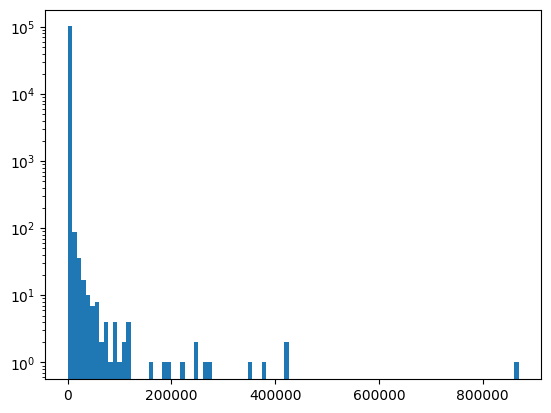

In [239]:
frequencies = sorted(list(tokenizer.frequencies.values()), reverse=True)
print(frequencies[:10])
plt.hist(frequencies, bins=100, log=True)

🚧 **Question** 🚧

What do you think of the repartition?

**Answer**

The distribution is very strongly tailed, which only makes sense because some words occur way more often than others. For example, the peak on the far right definitely corresponds to the word "the"



🚧 **TODO** 🚧

Plot the frequencies repartition. Find the best corresponding Zipf law (seen during the course) and plot it on the same figure.

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[869211, 423347, 421876, 378005, 349147, 273189, 263944, 243970, 243951, 221852]


/tmp/ipykernel_9699/4046479213.py:5: RuntimeWarning: overflow encountered in power
  normalizing_constant = np.sum(1 / np.arange(1, 10000, 1) ** alpha)
/tmp/ipykernel_9699/4046479213.py:6: RuntimeWarning: overflow encountered in power
  return 1 / rank**alpha / normalizing_constant
/tmp/ipykernel_9699/4046479213.py:13: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(zipf_law, ranks, frequencies)


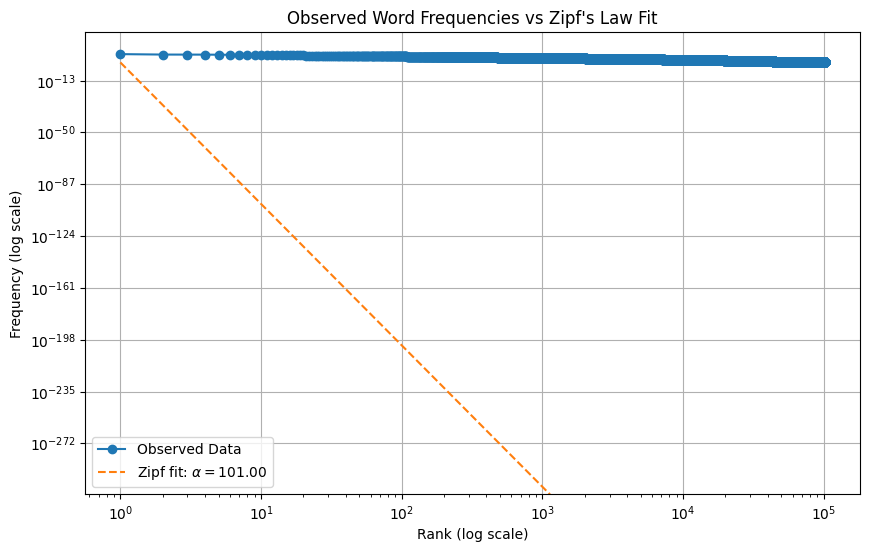

In [240]:
from scipy.optimize import curve_fit


def zipf_law(rank, alpha):
    normalizing_constant = np.sum(1 / np.arange(1, 10000, 1) ** alpha)
    return 1 / rank**alpha / normalizing_constant


ranks = list(range(1, len(frequencies) + 1))

print(ranks[:10])
print(frequencies[:10])
params, _ = curve_fit(zipf_law, ranks, frequencies)

# Step 7: Plot the actual word frequencies and the fitted Zipf law
plt.figure(figsize=(10, 6))

# Plot actual data (frequencies vs ranks)
plt.loglog(ranks, frequencies, label="Observed Data", marker="o")

# Plot the best fitting Zipf's law
plt.loglog(
    ranks,
    zipf_law(ranks, *params),
    label=f"Zipf fit: $\\alpha = {params[0]:.2f}$",
    linestyle="--",
)

# Labels and titles
plt.xlabel("Rank (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Observed Word Frequencies vs Zipf's Law Fit")
plt.legend()
plt.grid(True)
plt.show()

## III - DataLoading

This final part aims at making your dataset compatible with PyTorch.

### Text representation

Since we plan to work with PyTorch, we need to work with `tensors`. But since a text is only composed of strings, we need to find some numerical representations for the text.

The most basic method is to represent a text by list of tokens. We already used a simple WhiteSpace tokenizer earlier to analyze our texts before cleaning. Now we will use it to *represent* the texts.

🚧 **TODO** 🚧

Modify the code of the `WhiteSpaceTokenizer` so that it could encode a text into a list of token ids and do the reverse (i.e. decode a list of token ids to a text).

In [241]:
class WhiteSpaceTokenizer:
    def __init__(self):
        # The vocabulary will store the mapping between text tokens and their id.
        self.vocab = {}
        self.id_to_token = {}

        # We will keep track of the number of times a word appears in the corpus.
        self.frequencies = {}

    def split_text(self, text: str) -> List[str]:
        """Converts the text to a list of tokens (substrings)."""
        return text.split(" ")

    def encode(self, text: str) -> List[int]:
        """Take a text as input and return its associated tokenization, as a list of ids."""
        encoded_text = []
        for word in self.split_text(text):
            try:
                encoded_text.append(self.vocab[word])
            except KeyError:
                encoded_text.append(self.vocab["<UNK>"])
        return encoded_text

    def decode(self, ids: List[int]) -> str:
        decoded_text = []
        for id in ids:
            try:
                decoded_text.append(self.id_to_token[id])
            except KeyError:
                decoded_text.append("<UNK>")
        return " ".join(decoded_text)

    def fit(self, corpus: List[str]):
        """Fits the tokenizer to a list of texts to construct its vocabulary."""
        current_id = 0
        for text in tqdm(corpus):

            # Split into substrings.
            list_tokens = self.split_text(text)

            for token in list_tokens:

                # Add the token to the vocabulary
                token_id = self.vocab.get(token, None)

                token_not_in_vocab = token_id is None
                if token_not_in_vocab:
                    self.vocab[token] = current_id
                    self.id_to_token[current_id] = token
                    self.frequencies[current_id] = 0
                    token_id = current_id
                    current_id += 1

                self.frequencies[token_id] += 1

        # Total number of words in vocab.
        self.num_words = len(self.vocab)
        print(f"Built a vocabulary of {self.num_words} words.")

        # Creating an UNK token for out-of-vocabulary words.
        self.vocab["<UNK>"] = self.num_words
        self.id_to_token[self.num_words] = "<UNK>"

🔴 **TEST**

In [242]:
tokenizer = WhiteSpaceTokenizer()
toy_dataset = ["the cat is in the kitchen", "i have a dog"]
tokenizer.fit(toy_dataset)
text = "i have a kitchen"
assert tokenizer.encode(text) == [5, 6, 7, 4]
assert tokenizer.decode([0, 1, 2, 7, 8]) == "the cat is a dog"

  0%|          | 0/2 [00:00<?, ?it/s]

Built a vocabulary of 9 words.


🚧 **TODO** 🚧 Now fit it on your dataset.

In [243]:
tokenizer = WhiteSpaceTokenizer()
tokenizer.fit(clean_column)

  0%|          | 0/62155 [00:00<?, ?it/s]

Built a vocabulary of 101917 words.


In [244]:
# print 10 first elements of the vocabulary
print(list(tokenizer.vocab.items())[:10])
print(tokenizer.encode("i have a kitchen"))

[('once', 0), ('again', 1), ('mr', 2), ('costner', 3), ('has', 4), ('dragged', 5), ('out', 6), ('a', 7), ('movie', 8), ('for', 9)]
[27, 37, 7, 1002]


🚧 **Question** 🚧
Look at the following code:

In [245]:
tokenizer.encode("the king is in the câstle")

[16, 3510, 57, 39, 16, 101917]

a) Does it raise an exception? Explain what is the problem with the above situation.

b) In which real life scenario could such a situation appear?

**Answer**

a) This does raise a KeyError which arises because the word câstle does not appear in the vocabulary of the "training" dataset

b) This can perfectly appear in a real life situation, for instance if a text at "test" time covers a new topic that was not covered in the training dataset. For instance, if I submit a NeurIPS paper to a tokenizer fitted on IMDB dataset, it's not going to be able to encode and decode all the technical terms in the paper

🚧 **TODO** 🚧

Propose a simple modification of the tokenizer code such that it doesn't raise an exception anymore. It should handle the presence of any unknown token.

The following code should't raise any exception.

🔴 **TEST**

In [246]:
allowed_characters = (string.ascii_uppercase + string.digits).replace(" ", "")
for _ in range(1000):
    word_that_do_not_exist = "".join(random.choices(allowed_characters, k=100))
    encoding = tokenizer.encode(f"the king is in the {word_that_do_not_exist}")
    assert tokenizer.decode(encoding) == "the king is in the <UNK>"

### Dataset for PyTorch
We will be working wtth PyTorch most of the time.
A good practice is to always iterate through a `torch.utils.data.DataLoader`, coupled with `torch.utils.data.Dataset`.

🚧 **TODO** 🚧

We will construct our custom `Dataset` class, that should be fully compatible with the PyTorch API. According to the [documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files), such a dataset should implement at least three methods, `__init__`, `__len__`, `__getitem__`. Complete the following code such that the dataset yields a list of texts.

Requirements:
1. The dataset class should read the data from the csv_file stored in `DATA_PATH`.
2. The dataset should output the raw text, without any cleaning.

In [247]:
from torch.utils.data import Dataset


class IMDBDataset(Dataset):
    def __init__(self, file_path: str):
        self.data = pd.read_csv(file_path, dtype={"review": "string", "label": int})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        return self.data.loc[idx, "review"], self.data.loc[idx, "label"]

🔴 **TEST**

In [248]:
imdb_dataset = IMDBDataset(file_path=DATA_PATH)
text, label = imdb_dataset[0]
assert text == text_column[0]
assert label == label_column[0]

### DataLoader for PyTorch

Now that the dataset is ready, we should be able to iterate through it. This is done with a `DataLoader`.

The `DataLoader` also has some handy functionnalities:
1. Batch iteration.
2. Collate function.

The collate function corresponds to the argument `collate_fn` of the constructor of `torch.utils.data.DataLoader`.

This function is applied on the fly to each sample of the dataset.

Our `IMDBDataset` only outputs raw texts. During the iteration through the `DataLoader`, we would like to:
1. Clean the dataset with our cleaning function `preprocess_text`.
2. Convert the text to a list of tokens.
3. The `DataLoader`, for a batch size of `N`, should yield a dictionnary `{"token_ids": ..., "labels": ...,}` with `"token_ids"` corresponding to a list of `N` lists of tokens ids, and `"labels"` to a list of size `N` with the corresponding labels.

🚧 **TODO** 🚧

Write the `collate_fn` function so that the above requirements are satisfied (i.e., clean and tokenize).

In [249]:
def collate_fn(batch):
    token_ids = [tokenizer.encode(preprocess_text(text)) for text, _ in batch]
    labels = [label for _, label in batch]

    return {"token_ids": token_ids, "labels": labels}

In [250]:
from torch.utils.data import DataLoader

🔴 **TEST**

In [251]:
for batch_size in range(1, 10):
    dataloader = DataLoader(
        dataset=imdb_dataset, batch_size=batch_size, collate_fn=collate_fn
    )
    for batch in dataloader:
        token_ids = batch["token_ids"]
        labels = batch["labels"]
        assert len(token_ids) == batch_size
        assert len(labels) == batch_size
        assert isinstance(token_ids[0][0], int)
        assert (isinstance(labels[0], int)) or isinstance(labels[0], np.int64)
        break

🚧 **Question** 🚧

Write a concise summary on what you learned with this lab.

**Answer**

Learned about the collate function and how useful it is. 
Practiced pytorch and numpy skills